# Base Model

Blog: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Source code: https://github.com/hlamba28/Automatic-Image-Captioning

In [33]:
# import necessary packages
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, os.path.abspath('../scripts'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
FLICKR8K_TEXT = '../Flickr8k_text'
FLICKR8K_DATASET = '../Flicker8k_Dataset'

## 1 - Load, clean, save captions


Load the text file containing all the image id's and captions. We can download it from github. The data is in the file called "Flickr8k.token.txt" in the text zip file. 



We create a function load_doc to do this, so we can use it inside later functions.

In [137]:
from helper import *

In [138]:
doc = load_doc(f'{FLICKR8K_TEXT}/Flickr8k.token.txt')
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


As we can see from the output, we have in each line  the image id, the caption number and the caption itself.

We want to spilt each line into key value pairs, with the keys being image id's and the values being a list of captions 0-4.

In [139]:
# create a map of image ids with related descriptions
descriptions = load_descriptions(doc)
print('Loaded: ', len(descriptions))

Loaded:  8092


We need to remove punctuation and anything else not words, overwrite descriptions dictionary with cleaned version.

In [140]:
clean_descriptions(descriptions)
save_descriptions(descriptions, 'descriptions.txt')

## 2 - Load, clean, save images

We can also get this straight from github, takes about 8 mins to download, but we will save the features in a file so we only need to download once.

In [143]:
train_img_paths, dev_img_paths, test_img_paths = load_train_dev_test_image_paths(
    f'{FLICKR8K_DATASET}/*.jpg', 
    FLICKR8K_TEXT,
)

## 3 - Extract image features

The CNN prebuilt model used is InceptionV3, with imagenet weights.

In [11]:
# Load the inception v3 model
inception_v3_model = InceptionV3(weights='imagenet')

The last layer of InceptionV3 is a dense layer of size 2048.

In [142]:
# Create a new model, by removing the last layer (output layer) from the inception v3
image_features_extract_model = Model(inception_v3_model.input, inception_v3_model.layers[-2].output)

We need to run our training images through model_new (forward pass) to get our feature vectors 
and reshape to (2048, ) to input to the caption model.

In [13]:
from helper import extract_features_from_images

Encode training images - THIS TAKE A LONG TIME, RUN ON GPU if possible

In [ ]:
image_encodings_train = extract_features_from_images(
    image_path_list=train_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='train_image_encodings.pickle',
)

In [ ]:
image_encodings_dev = extract_features_from_images(
    image_path_list=dev_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='dev_image_encodings.pickle',
)

In [ ]:
image_encodings_test = extract_features_from_images(
    image_path_list=test_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='test_image_encodings.pickle',
)

## 4 - Load and Preprocess clean data


Wrap with START and END tokens for each image caption in the train dataset

In [57]:
from helper import add_start_end_tokens

train_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in train_img_paths]
train_descriptions = add_start_end_tokens('descriptions.txt', train_image_ids)

In [72]:
train_image_features = load(open("Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_image_features))

Photos: train=6000


Create a vocbulary of all the unqiue words in our train captions data, print size (7578). This is a lot, and the frequency of most of these words will be low.

Instead we will take the words that occur >10 times in the vocabulary, to be more robust to outliers, and to reduce memory and speed up training.

In [146]:
from collections import Counter

all_train_captions = [desc 
                      for desc_list in train_descriptions.values() 
                      for desc in desc_list]

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = Counter([word for caption in all_train_captions for word in caption.split(' ')])
vocabs = [word for word, count in word_counts.items() if count >= word_count_threshold]
print(f'Reduced vocab size from {len(word_counts)} -> {len(vocabs)}')

Reduced vocab size from 7578 -> 1651


We need to index our vocab with an integer, since our input to the model must be numeric. We can use this indexing to recall the words for model output. 

We must add one more item to the vocab size for our 0 padding.

In [134]:
# index our vocab to assign a number to each word, important for model input.
ixtoword = {}
wordtoix = {}

for ix, w in enumerate(vocabs):
    wordtoix[w] = ix + 1
    ixtoword[ix+1] = w

# get vocab size to put into embedding layer in the model
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# save our wordtoix dictionary as pickle to recall later for evaluation and prediction
with open("Pickle/wordtoix.pkl", "wb") as encoded_pickle:
    dump(wordtoix, encoded_pickle)

In [152]:
# determine the maximum sequence length in the training captions
max_length = max(len(caption.split()) for caption in all_train_captions)
print('Description Length: ', max_length)

Description Length:  34


## 5 - Build Base model

In [124]:
# feature extractor model
image_inputs = Input(shape=(2048,))
fe1 = Dropout(0.5)(image_inputs)
fe2 = Dense(256, activation='relu')(fe1)

# sequence model
word_seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(word_seq_inputs)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
base_model = Model(inputs=[image_inputs, word_seq_inputs], outputs=outputs)
base_model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(base_model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 256)      422912      input_11[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_10[0][0]                   
____________________________________________________________________________________________

## 6 - Train model

In [125]:
from helper import data_generator

In [126]:
# Define training params
epochs = 2
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [127]:
# Loop over 10 epochs using data generator, and save to file on each iteration
for i in range(epochs):
    generator = data_generator(
        train_descriptions, 
        train_image_features, 
        wordtoix,
        max_length, 
        vocab_size,
        number_pics_per_batch,
    )
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
 822/2000 [===========>..................] - ETA: 5:44 - loss: 4.5602

KeyboardInterrupt: 

After 10 epochs the loss went from 3.38 to 2.52. could still be room to reduce the loss further even with this basic model. We need to check for overfitting first by evaluating.

## 7 - Evaluate model



In [0]:
def greedySearch(photo, model):
    in_text = '<START>'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == '<END>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### BLEU

The primary programming task for a BLEU implementor is to compare n-grams of the candidate with the n-grams of the reference translation and count the number of matches. These matches are position-independent. The more the matches, the better the candidate translation is.

Cumulative N-Gram Scores
Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.

The cumulative and individual 1-gram BLEU use the same weights, e.g. (1, 0, 0, 0). The 2-gram weights assign a 50% to each of 1-gram and 2-gram and the 3-gram weights are 33% for each of the 1, 2 and 3-gram scores. The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores. 

Source - https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

Code for evaluation adapted from https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/


In [153]:
def evaluate_model(model, descriptions, photos):
    actual, predicted = list(), list()
    # step over the whole dataset
    for key, desc_list in descriptions.items():
        # generate descriptions
        yhat = greedySearch(photos[key].reshape((1,2048)), model)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU scores
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))  

In [0]:
# load training dataset (6K)
filename_dev = f'{FLICKR8K_TEXT}/Flickr_8k.devImages.txt'
dev = load_set(filename_dev)

In [0]:
# prepare dev set
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
# load dev images
dev_features = load(open("Pickle/encoded_dev_images.pkl", "rb"))
print('Photos: dev=%d' % len(dev_features))
# descriptions
dev_descriptions = add_start_end_tokens('descriptions.txt', dev_img_paths)
print('Descriptions: dev=%d' % len(dev_descriptions))
# load token index wordtoix if needed (component of greedySearch in evaluate function)
#wordtoix = load(open("Pickle/wordtoix.pkl", "rb"))

# put .jpg back into dev_descriptions to match dev_features
dev_descriptions = {k+'.jpg': v for k, v in dev_descriptions.items()}

# load the model
# model.load_weights('./model_weights/model_30.h5')
filename = './model_weights/model_9.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, dev_descriptions, dev_features)

In [177]:
evaluate_model(model, dev_descriptions, dev_features)

BLEU-1: 0.419459
BLEU-2: 0.240967
BLEU-3: 0.166875
BLEU-4: 0.079061


So we have about a 0.419 which means about 42% of words in the generated captions matched the original, and about 7% of generated 4-grams occured in the original. this is not a terrible score, but can likely be improved.

### ROUGE

ROUGE is a set of metric that generates the precision, recall, and F-score of a candidate with respect to references. ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. It is first proposed by Lin et al in their paper ROUGE: A Package for Automatic Evaluation of Summaries

* ROUGE-N: measures n-gram overlap statistics
* ROUGE-L: Longest Common Subsequence (LCS) based statistics. Longest common subsequence problem takes into account sentence level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically. An advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order. Since it automatically includes longest in-sequence common n-grams, you don’t need a predefined n-gram length.
* ROUGE-W: Weighted LCS-based statistics that favors consecutive LCSes
* ROUGE-S – Is any pair of word in a sentence in order, allowing for arbitrary gaps. This can also be called skip-gram coocurrence. For example, skip-bigram measures the overlap of word pairs that can have a maximum of two gaps in between words. As an example, for the phrase “cat in the hat” the skip-bigrams would be “cat in, cat the, cat hat, in the, in hat, the hat”.
* ROUGE-SU: Skip-bigram plus unigram-based co-occurrence statistics

SOurce - https://xiangyutang2.github.io/image-captioning/


In [0]:
#greedy rouge
from rouge import rouge


rouge_score = dict()
for image_fileName, reference_captions in image_captions_test.items():
    cand=[' '.join(image_captions_candidate[image_fileName])]
    ref_cap_reformat=list()
    for cap in reference_captions:
        ref_cap_reformat.append(' '.join(cap.split()[1:-1]))
    
    rouge_score[image_fileName] = rouge(cand, ref_cap_reformat)

#print(rouge_score)

# EXTRA CODE NOT NEEDED FOR BASE MODEL

In [178]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 285s 142ms/step - loss: 2.4862
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.4558
Epoch 1/1
2000/2000 [==============================] - 279s 139ms/step - loss: 2.4254
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 2.4008
Epoch 1/1
2000/2000 [==============================] - 271s 135ms/step - loss: 2.3775
Epoch 1/1
2000/2000 [==============================] - 266s 133ms/step - loss: 2.3559
Epoch 1/1
2000/2000 [==============================] - 268s 134ms/step - loss: 2.3384
Epoch 1/1
2000/2000 [==============================] - 264s 132ms/step - loss: 2.3208
Epoch 1/1
2000/2000 [==============================] - 266s 133ms/step - loss: 2.3065
Epoch 1/1
2000/2000 [==============================] - 266s 133ms/step - loss: 2.2915


Reduce the learning rate, increase batch size to slow descent

In [0]:
model.optimizer.lr = 0.0001
epochs = 20
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_batch

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4589
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4495
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4380
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4300
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4200
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4085
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3994
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3957
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3877
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3766


In [0]:
filename = './model_weights/model_30.h5'
model_30 = load_model(filename)
# evaluate model
evaluate_model(model_30, dev_descriptions, dev_features)

## UNUSED CODE FROM TUTORIAL

In [0]:
model.save_weights('./model_weights/model_30.h5')

In [0]:
model.load_weights('./model_weights/model_30.h5')

In [0]:
with open("Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

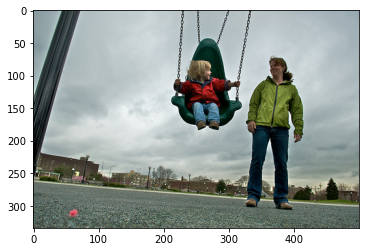

Greedy: boy in red shirt is climbing on swing set


In [0]:
# z+=1
pic = list(encoding_test.keys())[7]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

We can evaluate the model against our dev set

In [163]:
print(dev_descriptions)
print(sorted(dev_images))


{'1022454332_6af2c1449a.jpg': ['startseq child and woman are at waters edge in big city endseq', 'startseq large lake with lone duck swimming in it with several people around the edge of it endseq', 'startseq little boy at lake watching duck endseq', 'startseq young boy waves his hand at the duck in the water surrounded by green park endseq', 'startseq two people are at the edge of lake facing the water and the city skyline endseq'], '103106960_e8a41d64f8.jpg': ['startseq boy with stick kneeling in front of goalie net endseq', 'startseq child in red jacket playing street hockey guarding goal endseq', 'startseq young kid playing the goalie in hockey rink endseq', 'startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq', 'startseq hockey goalie boy in red jacket crouches by goal with stick endseq'], '1032122270_ea6f0beedb.jpg': ['startseq woman crouches near three dogs in field endseq', 'startseq three dogs are playing on grassy hill with blue sky

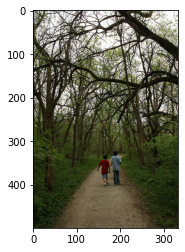

Greedy: man and woman are sitting on the edge of grassy hill


In [102]:
pic = list(encoding_dev.keys())[7]
image = encoding_dev[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image, model))

# Extension tasks

We try a few extensions to better the base model:

1. Use pretrained word embeddings in training (Glove6b200d), instead of getting the model to learn from the caption vocab alone.
2. We try different CNN architectures for the feature extractor
3. We add attention (Bahdanau)
4. We add noise to the text data, to reduce overfitting (https://arxiv.org/abs/1703.02573)

## Import packages 

In [1]:
# import necessary packages
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


Ensure the "Pickle" is in the current working directory. 
if you use a previously saved model make sure "model_weights" is there too.

In [24]:
# run this cell to load saved clean data for extention tasks

# load doc into memory
def load_doc(filename):
    with open(filename, 'r') as file:
        return file.read()

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load training dataset (6K)
filename ='/content/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# load descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# load images
train_features = load(open("Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

# load tokenizer/wordtoix
wordtoix = load(open("Pickle/wordtoix.pkl", "rb"))
print('Vocab_index: train=%d' % len(wordtoix))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocab_index: train=1651


In [25]:
# get vocab size to put into embedding layer in the model
vocab_size = len(wordtoix) + 1 # one for appended 0's
vocab_size

1652

In [26]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

## Use Glove embedding 

code source - https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ - alternate code source



### 1 - Download glove embedding matrix

In [28]:
# download glove model from web
!wget http://nlp.stanford.edu/data/glove.6B.zip
# unzip
!unzip glove.6B.zip
# save to directory
!mkdir glove & mv glove.*.txt glove/

--2020-06-15 11:43:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-15 11:43:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-15 11:43:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [32]:
# Load Glove vectors
#glove_dir = 'content/'
embeddings_index = {} # empty dictionary
f = open('/content/glove/glove.6B.300d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
# Consider only words which occur at least 5 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 2530


In [0]:
# index our vocab to assign a number to each word, important for model input.
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

# get vocab size to put into embedding layer in the model
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2531

In [35]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1652, 300)

In [53]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for large vocab size of 2531
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(2531, 300)

### 2-  - Build model with embedding matrix

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      759300      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_7[0][0]                    
____________________________________________________________________________________________

In [57]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### 3 - Prepare data and train

In [0]:
# Define training params
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [24]:
# Loop over 10 epochs using data generator, and save to file on each iteration
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_glove_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 175s 87ms/step - loss: 4.1280
Epoch 1/1
2000/2000 [==============================] - 172s 86ms/step - loss: 3.4225
Epoch 1/1
2000/2000 [==============================] - 174s 87ms/step - loss: 3.2002
Epoch 1/1
2000/2000 [==============================] - 171s 85ms/step - loss: 3.0618
Epoch 1/1
2000/2000 [==============================] - 169s 85ms/step - loss: 2.9648
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.8918
Epoch 1/1
2000/2000 [==============================] - 167s 84ms/step - loss: 2.8338
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.7855
Epoch 1/1
2000/2000 [==============================] - 165s 83ms/step - loss: 2.7455
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.7078


In [43]:
# Loop over 10 epochs using data generator, and save to file on each iteration
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_glove300_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 300s 150ms/step - loss: 3.3613
Epoch 1/1
2000/2000 [==============================] - 300s 150ms/step - loss: 3.1447
Epoch 1/1
2000/2000 [==============================] - 301s 151ms/step - loss: 3.0109
Epoch 1/1
2000/2000 [==============================] - 298s 149ms/step - loss: 2.9141
Epoch 1/1
2000/2000 [==============================] - 298s 149ms/step - loss: 2.8380
Epoch 1/1
2000/2000 [==============================] - 300s 150ms/step - loss: 2.7792
Epoch 1/1
2000/2000 [==============================] - 308s 154ms/step - loss: 2.7283
Epoch 1/1
2000/2000 [==============================] - 294s 147ms/step - loss: 2.6876
Epoch 1/1
2000/2000 [==============================] - 292s 146ms/step - loss: 2.6533
Epoch 1/1
2000/2000 [==============================] - 296s 148ms/step - loss: 2.6235


In [60]:
# Loop over 10 epochs using data generator, and save to file on each iteration
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_glove300_lrgvocab' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 296s 148ms/step - loss: 4.2271
Epoch 1/1
2000/2000 [==============================] - 288s 144ms/step - loss: 3.4736
Epoch 1/1
2000/2000 [==============================] - 283s 141ms/step - loss: 3.2290
Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 3.0786
Epoch 1/1
2000/2000 [==============================] - 284s 142ms/step - loss: 2.9669
Epoch 1/1
2000/2000 [==============================] - 292s 146ms/step - loss: 2.8766
Epoch 1/1
2000/2000 [==============================] - 293s 146ms/step - loss: 2.8094
Epoch 1/1
2000/2000 [==============================] - 284s 142ms/step - loss: 2.7513
Epoch 1/1
2000/2000 [==============================] - 287s 144ms/step - loss: 2.7049
Epoch 1/1
2000/2000 [==============================] - 294s 147ms/step - loss: 2.6652


### 4 - Evaluate

In [0]:
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final



In [0]:
def evaluate_model(model, descriptions, photos):
  actual, predicted = list(), list()
  # step over the whole dataset
  for key, desc_list in descriptions.items():
    # generate descriptions
    yhat = greedySearch(photos[key].reshape((1,2048)), model)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  # calculate BLEU scores
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))  



In [0]:
# load training dataset (6K)
filename_dev = '/content/Flickr_8k.devImages.txt'
dev = load_set(filename_dev)

In [32]:
# prepare dev set
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
# load dev images
dev_features = load(open("Pickle/encoded_dev_images.pkl", "rb"))
print('Photos: dev=%d' % len(dev_features))
# descriptions
dev_descriptions = load_clean_descriptions('descriptions.txt', dev)
print('Descriptions: dev=%d' % len(dev_descriptions))
# load token index wordtoix if needed (component of greedySearch in evaluate function)
#wordtoix = load(open("Pickle/wordtoix.pkl", "rb"))

# put .jpg back into dev_descriptions to match dev_features
dev_descriptions = {k+'.jpg': v for k, v in dev_descriptions.items()}

# load the model
# model.load_weights('./model_weights/model_30.h5')
filename = './model_weights/model_glove_9.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, dev_descriptions, dev_features)

Photos: dev=1000
Descriptions: dev=1000
BLEU-1: 0.411002
BLEU-2: 0.231302
BLEU-3: 0.160571
BLEU-4: 0.075528


In [50]:
# load the model
# model.load_weights('./model_weights/model_30.h5')
filename = './model_weights/model_glove300_9.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, dev_descriptions, dev_features)

Photos: dev=1000
Descriptions: dev=1000
BLEU-1: 0.427984
BLEU-2: 0.244840
BLEU-3: 0.172655
BLEU-4: 0.083322


In [70]:
# load the model
# model.load_weights('./model_weights/model_30.h5')
filename = './model_weights/model_glove300_lrgvocab9.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, dev_descriptions, dev_features)

BLEU-1: 0.414275
BLEU-2: 0.228759
BLEU-3: 0.155715
BLEU-4: 0.070869


## Use ELMO embedding - cannot be used in Tensor flow 2!

https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/



In [0]:
import tensorflow_hub as hub


In [0]:
# Extract ELMo features 
elmo_embeddings = elmo(wordtoix.tolist(), signature="default", as_dict=True)["elmo"]

elmo_embeddings.shape

In [69]:
url = "https://tfhub.dev/google/elmo/3"
elmo_embed = hub.Module(url)

RuntimeError: ignored

In [0]:
# Load Glove vectors
#glove_dir = 'content/'
embeddings_index = {} # empty dictionary
f = open('/content/glove/glove.6B.300d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# length of elmo word vector is the embedding_dim
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1652, 300)

## Attention

## Embeddings

## Text manipulation